<a href="https://colab.research.google.com/github/anchal0152/ml/blob/main/Diabetes_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import itertools
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer

import warnings
warnings.simplefilter(action="ignore")

# 2. Adjusting Row Column Settings

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 3. Loading the data Set

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/datascience/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# 4. Missing Value Analysis

In [5]:
# Detection of variables with missing observations filled with zero in the data set.

zero_colunms = [col for col in df.columns if (df[col].min() == 0 and col not in  ["Pregnancies", "Outcome"])]

In [6]:
zero_colunms

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [7]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [8]:
# Filling the missing observations in the dataset with NaN that are filled with zero.

for col in zero_colunms:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [9]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [10]:
def missing_values_table(dataframe, na_name=False, plot=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if plot:
        # Plotting the missing values
        plt.figure(figsize=(10, 8))
        bars = plt.bar(missing_df.index, missing_df['ratio'], color='purple')
        plt.xlabel('Features')
        plt.ylabel('Percentage of Missing Values')
        plt.title('Missing Values by Feature')

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%', ha='center', va='bottom')

        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    if na_name:
        return na_columns

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


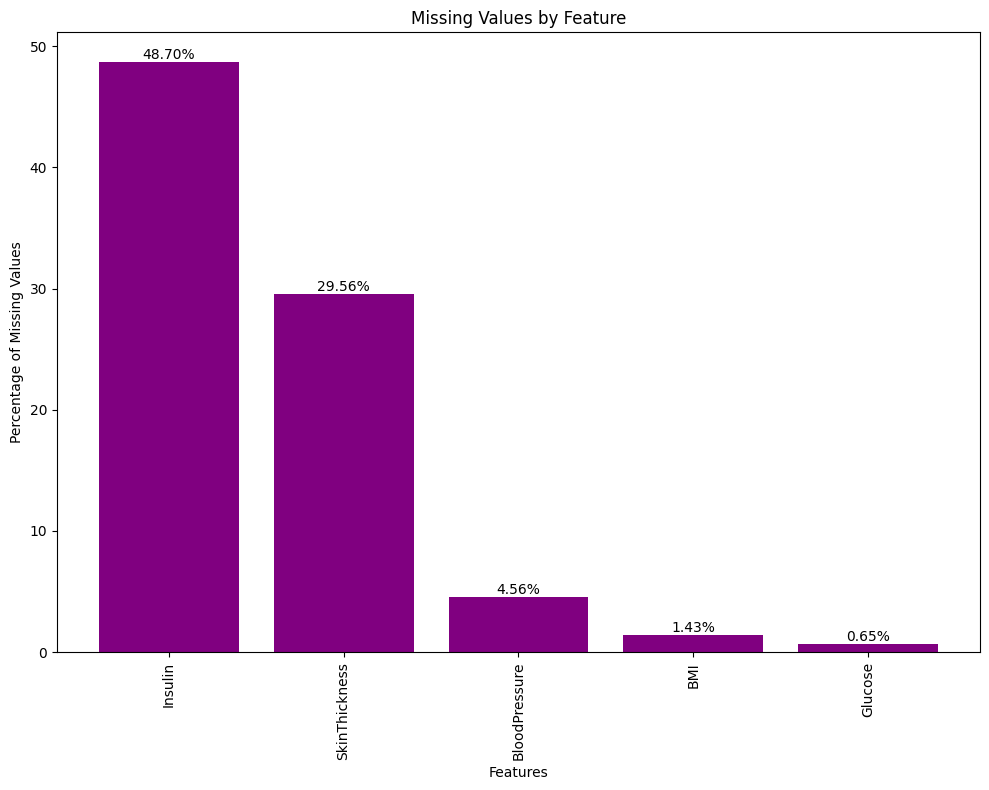

In [11]:
na_columns = missing_values_table(df, na_name=True, plot=True)

In [12]:
def missing_vs_target(dataframe, target, na_columns, plot=False):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
        if plot:
            # Plotting the target mean by NA flag
            plt.figure(figsize=(6, 4))
            temp_df.groupby(col)[target].mean().plot(kind='bar', color='purple')
            plt.xlabel(col)
            plt.ylabel('Target Mean')
            plt.title(f'Target Mean by {col}')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
            print("######################################################################")

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5




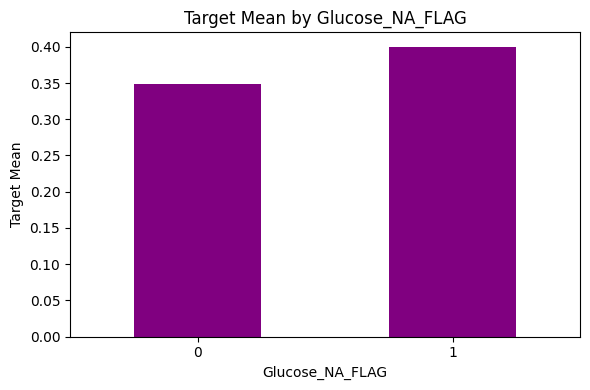

######################################################################
                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35




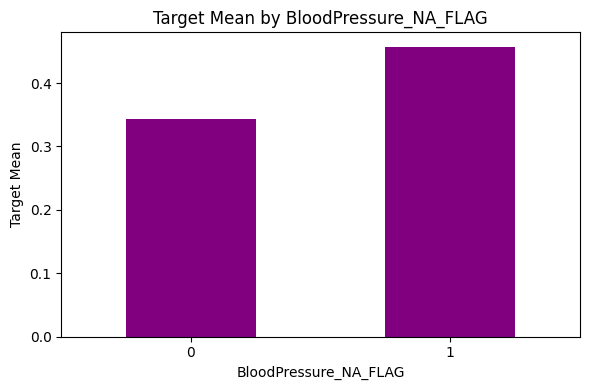

######################################################################
                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227




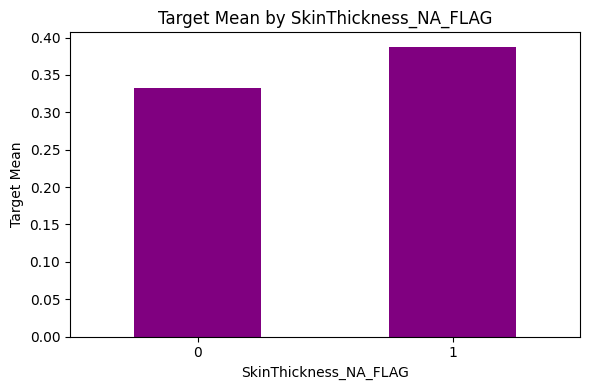

######################################################################
                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374




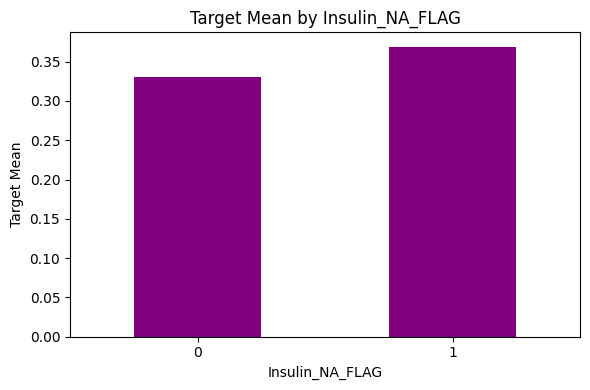

######################################################################
             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




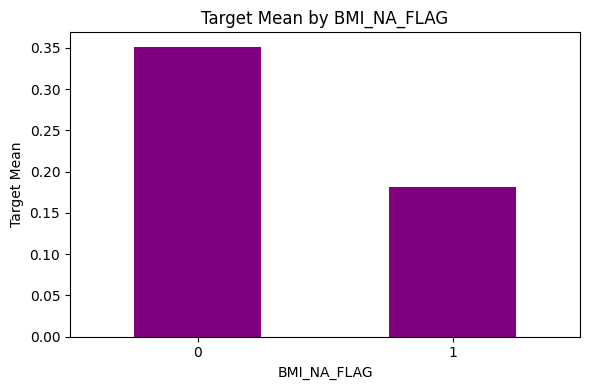

######################################################################


In [13]:
missing_vs_target(df, "Outcome", na_columns, plot=True)

In [14]:
"""
# Option 1
# Filling the missing observations filled with NaN in the data set with the median value of that column.

for col in zero_colunms:
    df.loc[df[col].isnull(), col] = df[col].median()

df.isnull().sum()

df.head(10)
"""

'\n# Option 1\n# Filling the missing observations filled with NaN in the data set with the median value of that column.\n\nfor col in zero_colunms:\n    df.loc[df[col].isnull(), col] = df[col].median()\n\ndf.isnull().sum()\n\ndf.head(10)\n'

In [15]:
# Option 2
# Filled KNN Imputers

dff = df[na_columns]

In [16]:
rs = RobustScaler()

In [17]:
dff = pd.DataFrame(rs.fit_transform(dff), columns=dff.columns)

In [18]:
dff.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738,0.000,0.429,NaN,0.143
1,-0.762,-0.375,0.000,NaN,-0.626
2,1.571,-0.500,NaN,NaN,-0.989
3,-0.667,-0.375,-0.429,-0.273,-0.462
4,0.476,-2.000,0.429,0.378,1.187


In [19]:
dff = pd.DataFrame(KNNImputer(n_neighbors=5).fit_transform(dff), columns = dff.columns)

In [20]:
dff.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,0.738,0.000,0.429,0.624,0.143
1,-0.762,-0.375,0.000,-0.452,-0.626
2,1.571,-0.500,-0.243,0.819,-0.989
3,-0.667,-0.375,-0.429,-0.273,-0.462
4,0.476,-2.000,0.429,0.378,1.187


In [21]:
dff = pd.DataFrame(rs.inverse_transform(dff), columns=dff.columns)

In [22]:
df[na_columns] = dff

In [23]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,196.000,33.600,0.627,50,1
1,1,85.000,66.000,29.000,73.600,26.600,0.351,31,0
2,8,183.000,64.000,25.600,218.200,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1
5,5,116.000,74.000,24.200,85.000,25.600,0.201,30,0
6,3,78.000,50.000,32.000,88.000,31.000,0.248,26,1
7,10,115.000,69.400,36.600,123.200,35.300,0.134,29,0
8,2,197.000,70.000,45.000,543.000,30.500,0.158,53,1
9,8,125.000,96.000,40.200,163.600,31.100,0.232,54,1


In [24]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


# 5. Exploratory Data Analysis

In [25]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  \
0            6  148.000         72.000         35.000  196.000 33.600                     0.627   
1            1   85.000         66.000         29.000   73.600 26.600                     0.351   
2            8  183.000         64.000         25.600  218.200 23.300                     0.672   
3            1   89.000         66.000         23.000   94.000 28.100                     0.167   
4        

## Summary statistics

In [26]:
# Using describe() to calculate summary statistics
summary_stats = df.describe()
print(summary_stats)

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count      768.000  768.000        768.000        768.000  768.000 768.000   
mean         3.845  121.707         72.441         28.626  150.436  32.450   
std          3.370   30.445         12.218          9.573   96.716   6.890   
min          0.000   44.000         24.000          7.000   14.000  18.200   
25%          1.000   99.750         64.000         22.000   87.300  27.500   
50%          3.000  117.000         72.000         28.200  127.800  32.150   
75%          6.000  140.250         80.000         35.000  187.550  36.600   
max         17.000  199.000        122.000         99.000  846.000  67.100   

       DiabetesPedigreeFunction     Age  Outcome  
count                   768.000 768.000  768.000  
mean                      0.472  33.241    0.349  
std                       0.331  11.760    0.477  
min                       0.078  21.000    0.000  
25%                       0.244  24.000   

In [27]:
# Calculating mean, median, and mode
mean_values = df.mean()
median_values = df.median()
mode_values = df.mode().iloc[0]  # mode() returns a DataFrame

print("Mean values:\n", mean_values)
print("\nMedian values:\n", median_values)
print("\nMode values:\n", mode_values)

Mean values:
 Pregnancies                  3.845
Glucose                    121.707
BloodPressure               72.441
SkinThickness               28.626
Insulin                    150.436
BMI                         32.450
DiabetesPedigreeFunction     0.472
Age                         33.241
Outcome                      0.349
dtype: float64

Median values:
 Pregnancies                  3.000
Glucose                    117.000
BloodPressure               72.000
SkinThickness               28.200
Insulin                    127.800
BMI                         32.150
DiabetesPedigreeFunction     0.372
Age                         29.000
Outcome                      0.000
dtype: float64

Mode values:
 Pregnancies                  1.000
Glucose                     99.000
BloodPressure               70.000
SkinThickness               32.000
Insulin                    105.000
BMI                         31.600
DiabetesPedigreeFunction     0.254
Age                         22.000
Outcome       

## Data distributions (histograms, box plots)

### Capturing / Detecting Numeric and Categorical Variables6

In [28]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [29]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [30]:
cat_cols

['Outcome']

In [31]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [32]:
cat_but_car

[]

In [33]:
num_but_cat

['Outcome']

### Analysis of Categorical Variables

In [34]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


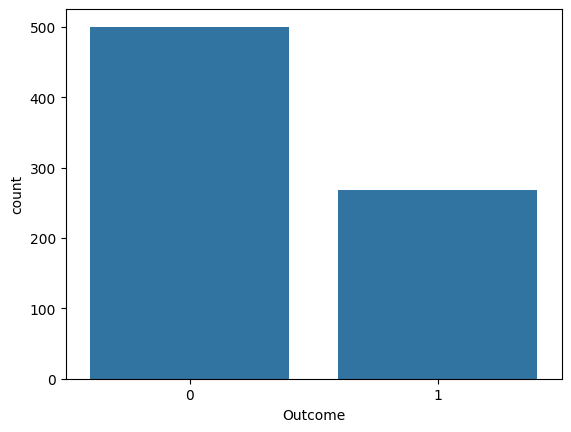

In [35]:
# We did it this way because there is only one categorical variable.

cat_summary(df, "Outcome", plot=True)

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


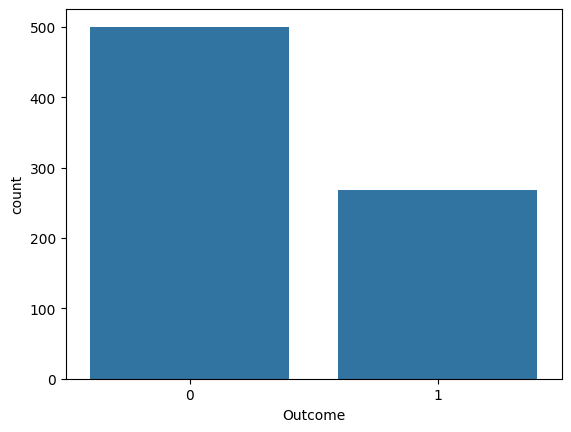

In [36]:
# If there were more than one categorical variable, we would loop through all categorical variables one by one as follows to run the function.

for col in cat_cols:
    cat_summary(df, col, plot=True)

### Analysis of Numerical Variables

In [37]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


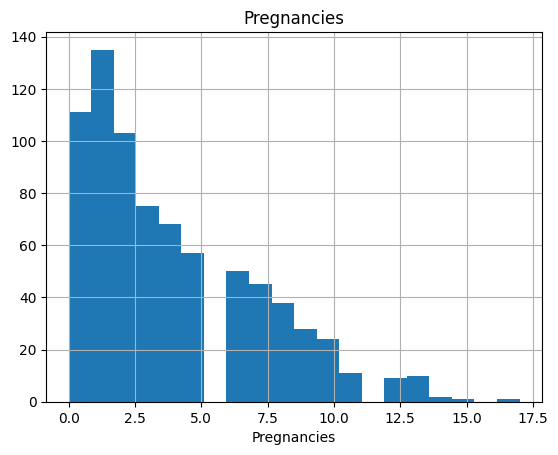

count   768.000
mean    121.707
std      30.445
min      44.000
5%       80.000
10%      86.700
20%      95.000
30%     102.100
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


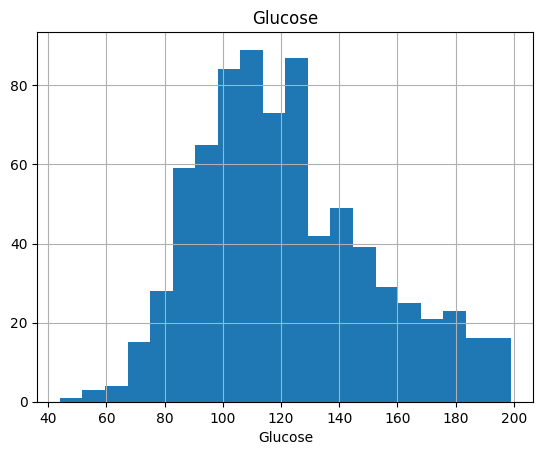

count   768.000
mean     72.441
std      12.218
min      24.000
5%       52.000
10%      58.000
20%      62.000
30%      66.000
40%      70.000
50%      72.000
60%      75.000
70%      78.000
80%      82.000
90%      88.000
95%      91.300
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


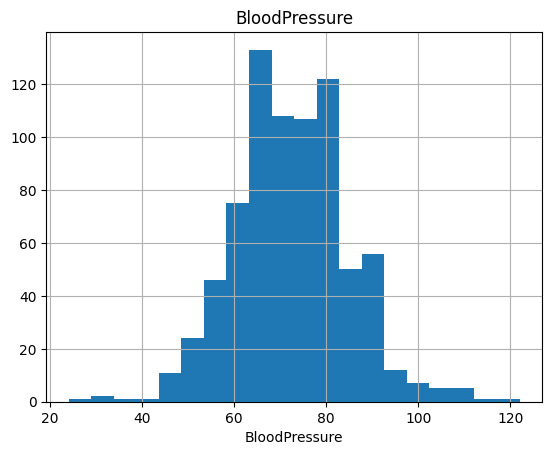

count   768.000
mean     28.626
std       9.573
min       7.000
5%       14.140
10%      17.000
20%      20.000
30%      23.000
40%      26.000
50%      28.200
60%      31.000
70%      33.000
80%      36.600
90%      41.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


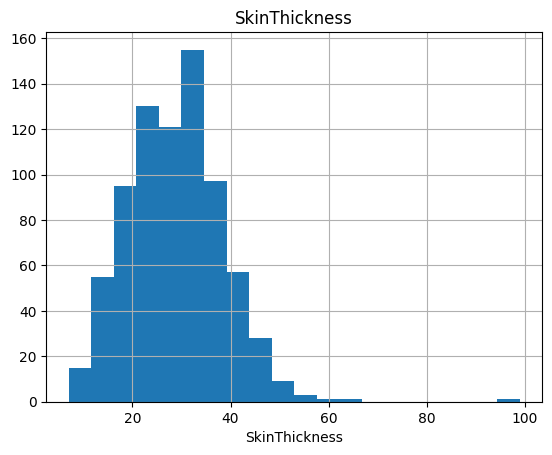

count   768.000
mean    150.436
std      96.716
min      14.000
5%       49.000
10%      58.280
20%      78.080
30%      96.000
40%     110.800
50%     127.800
60%     146.120
70%     175.000
80%     204.240
90%     267.200
95%     323.210
99%     519.900
max     846.000
Name: Insulin, dtype: float64


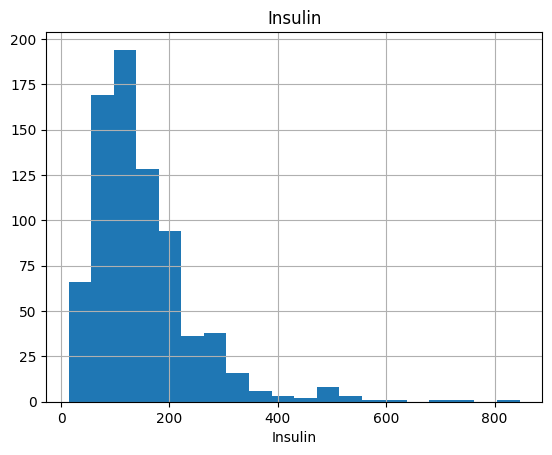

count   768.000
mean     32.450
std       6.890
min      18.200
5%       22.235
10%      24.000
20%      26.200
30%      28.410
40%      30.380
50%      32.150
60%      33.800
70%      35.500
80%      37.860
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


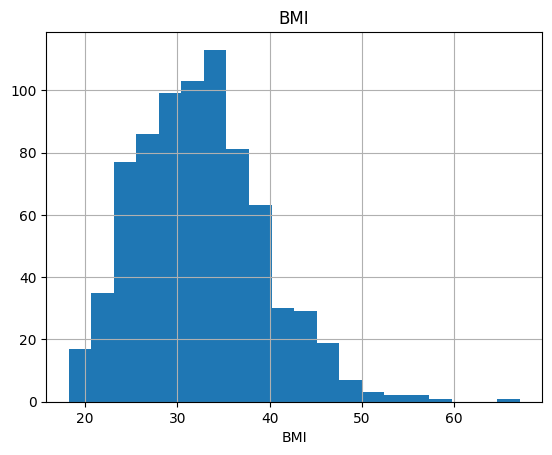

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


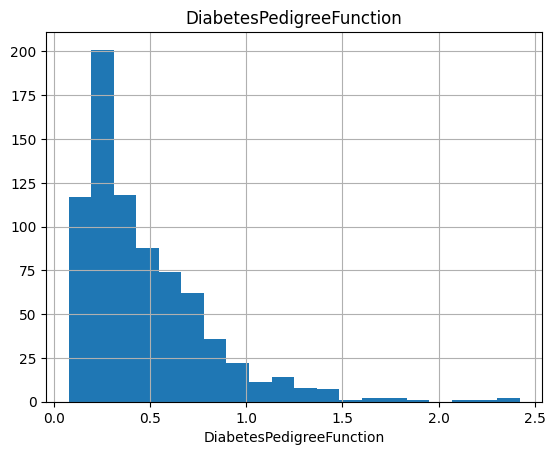

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


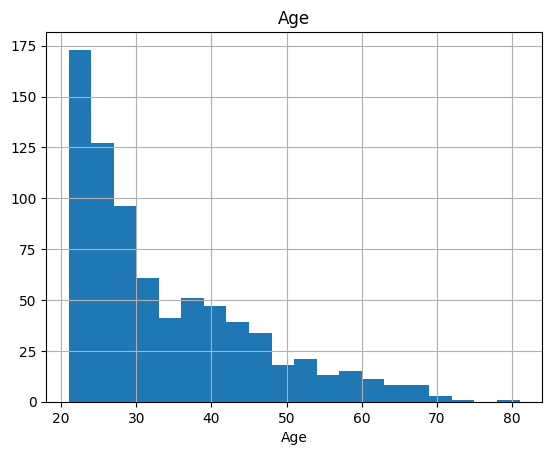

In [38]:
for col in num_cols:
    num_summary(df, col, plot=True)

### Analysis of Categorical Variables by Target

In [39]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.show(block=True)

         TARGET_MEAN
Outcome             
0              0.000
1              1.000




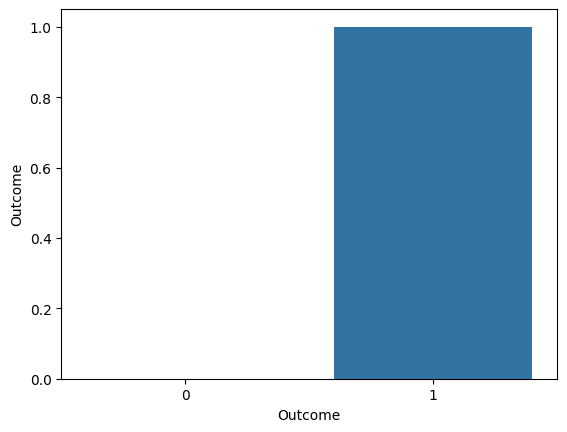

In [40]:
for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col, plot=True)

## Correlation Analysis

In [41]:
corr = df[num_cols].corr()

In [42]:
corr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000,0.128,0.217,0.091,0.043,0.025,-0.034,0.544
Glucose,0.128,1.000,0.234,0.245,0.623,0.233,0.137,0.267
BloodPressure,0.217,0.234,1.000,0.232,0.121,0.295,0.001,0.328
SkinThickness,0.091,0.245,0.232,1.000,0.269,0.685,0.132,0.118
Insulin,0.043,0.623,0.121,0.269,1.000,0.311,0.152,0.154
BMI,0.025,0.233,0.295,0.685,0.311,1.000,0.151,0.031
DiabetesPedigreeFunction,-0.034,0.137,0.001,0.132,0.152,0.151,1.000,0.034
Age,0.544,0.267,0.328,0.118,0.154,0.031,0.034,1.000


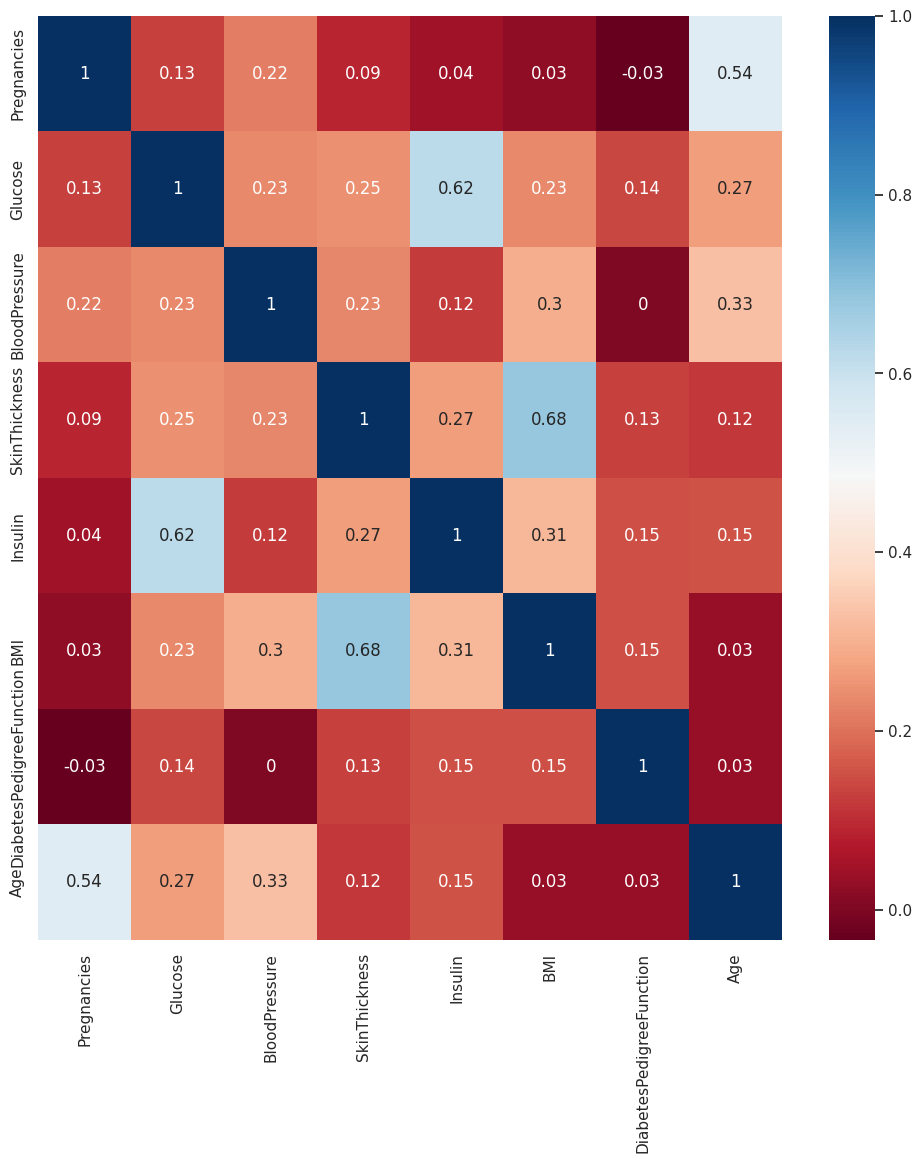

In [43]:
# Correlation heatmap without using functions

sns.set(rc={"figure.figsize": (12, 12)})
corr_values = corr.round(2)
sns.heatmap(corr, cmap="RdBu", annot=corr_values)
plt.show(block=True)

## Outlier detection & handling

In [44]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [45]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [46]:
def check_outlier(dataframe, col_name, plot=False):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    if outliers.any(axis=None):
        if plot:
            plt.figure(figsize=(8, 6))
            sns.boxplot(x=dataframe[col_name])
            plt.title(f'Outliers in {col_name}')
            plt.show()
        return True
    else:
        return False

In [47]:
def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

Pregnancies False
Glucose False
BloodPressure False


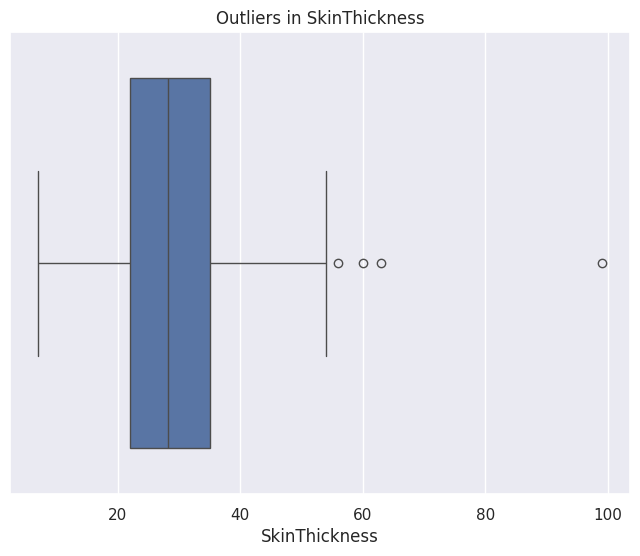

SkinThickness True


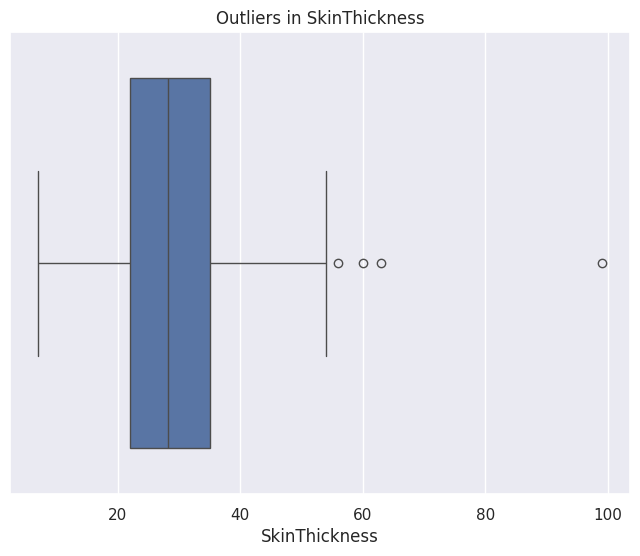

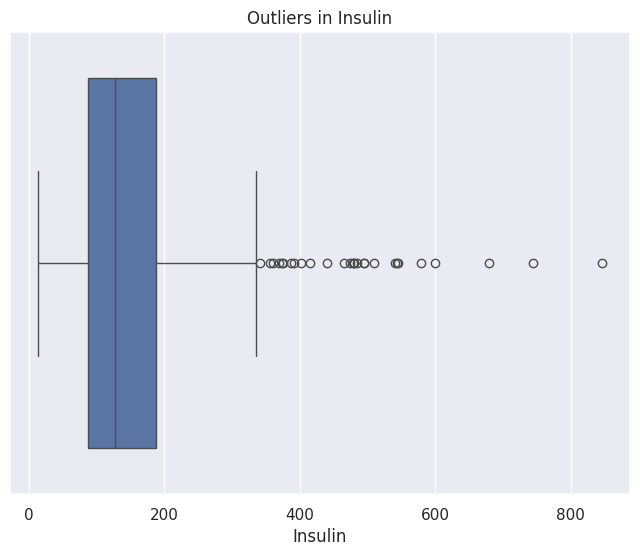

Insulin True


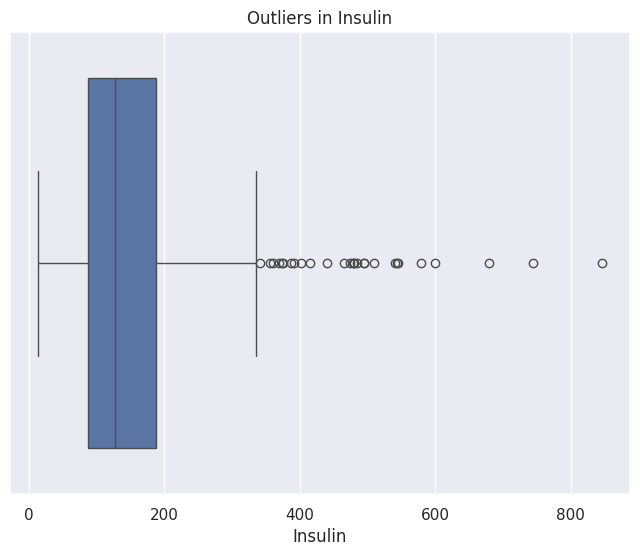

BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [48]:
for col in df.columns:
    print(col, check_outlier(df, col, plot=True))
    if check_outlier(df, col, plot=True):
        replace_with_thresholds(df, col)

In [49]:
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


## Normalize/standardize numerical features if needed.

In [50]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

         Pregnancies_mean
Outcome                  
0                   3.298
1                   4.866




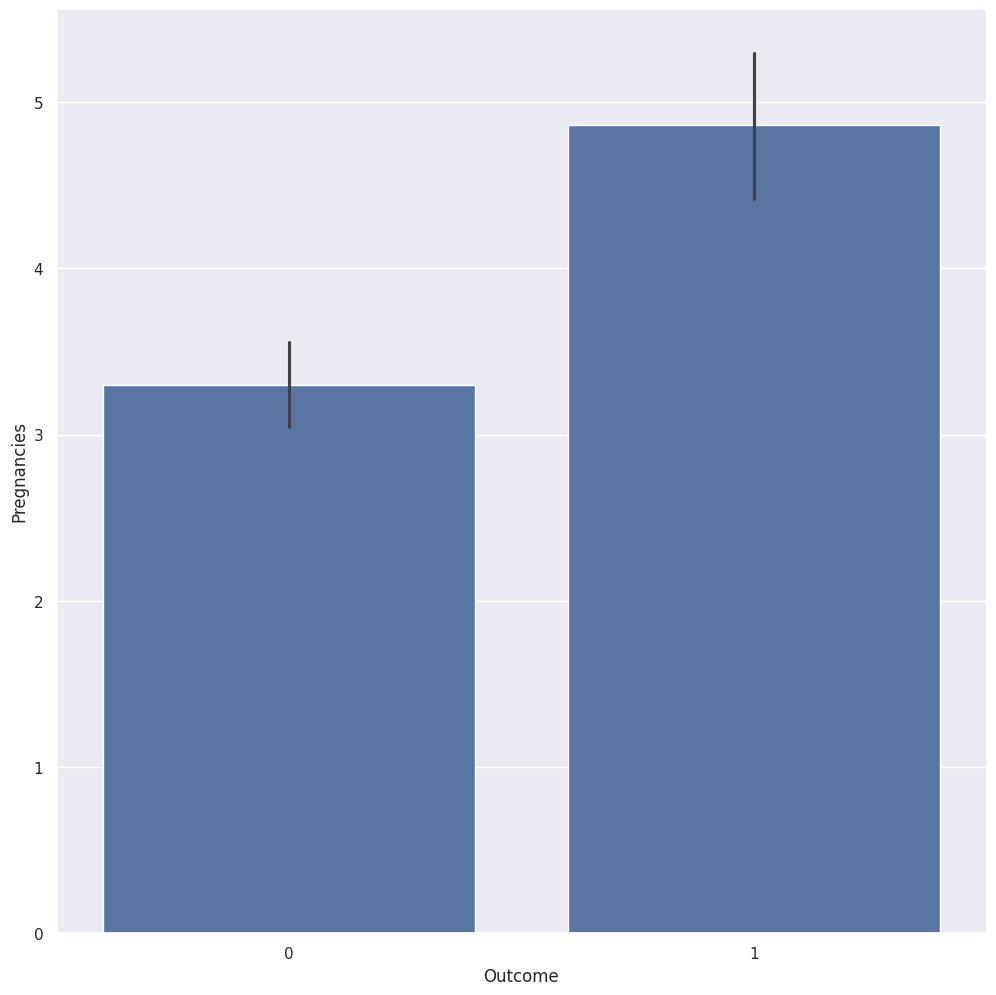

         Glucose_mean
Outcome              
0             110.711
1             142.220




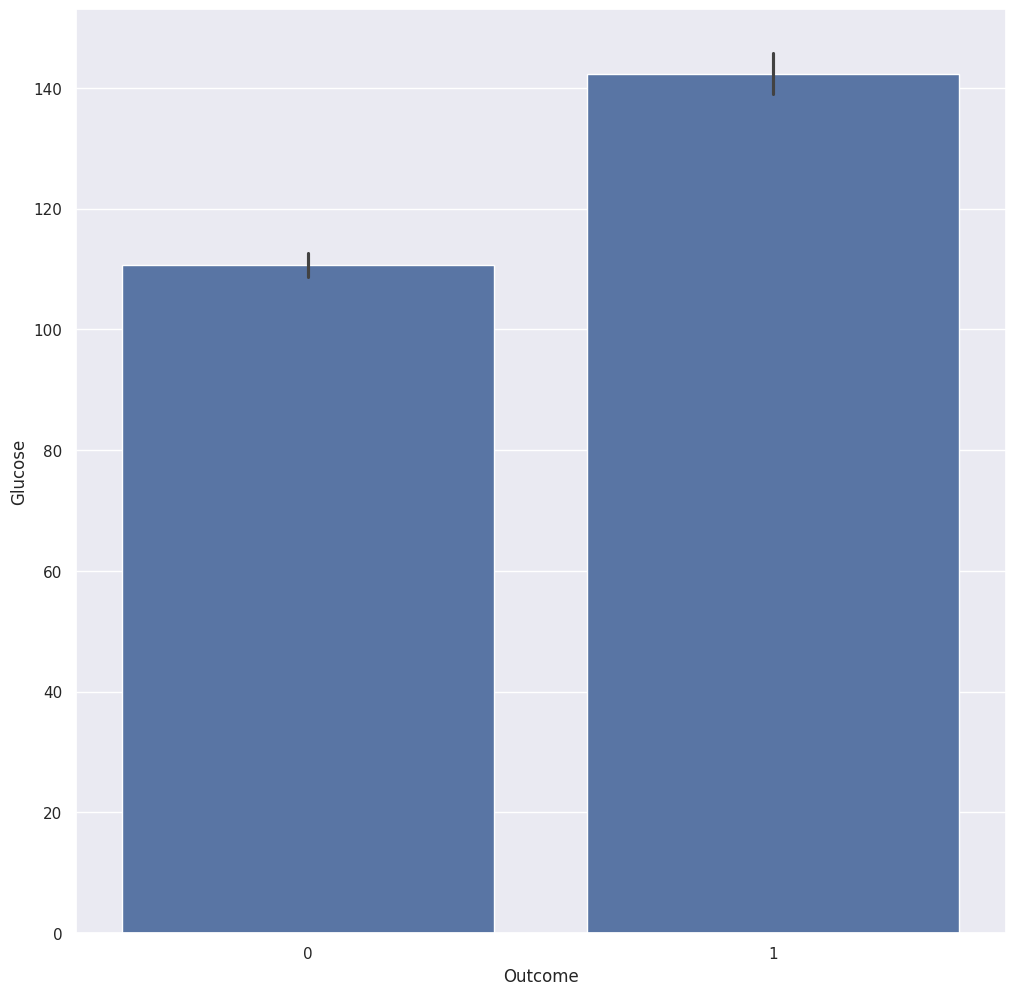

         BloodPressure_mean
Outcome                    
0                    70.822
1                    75.460




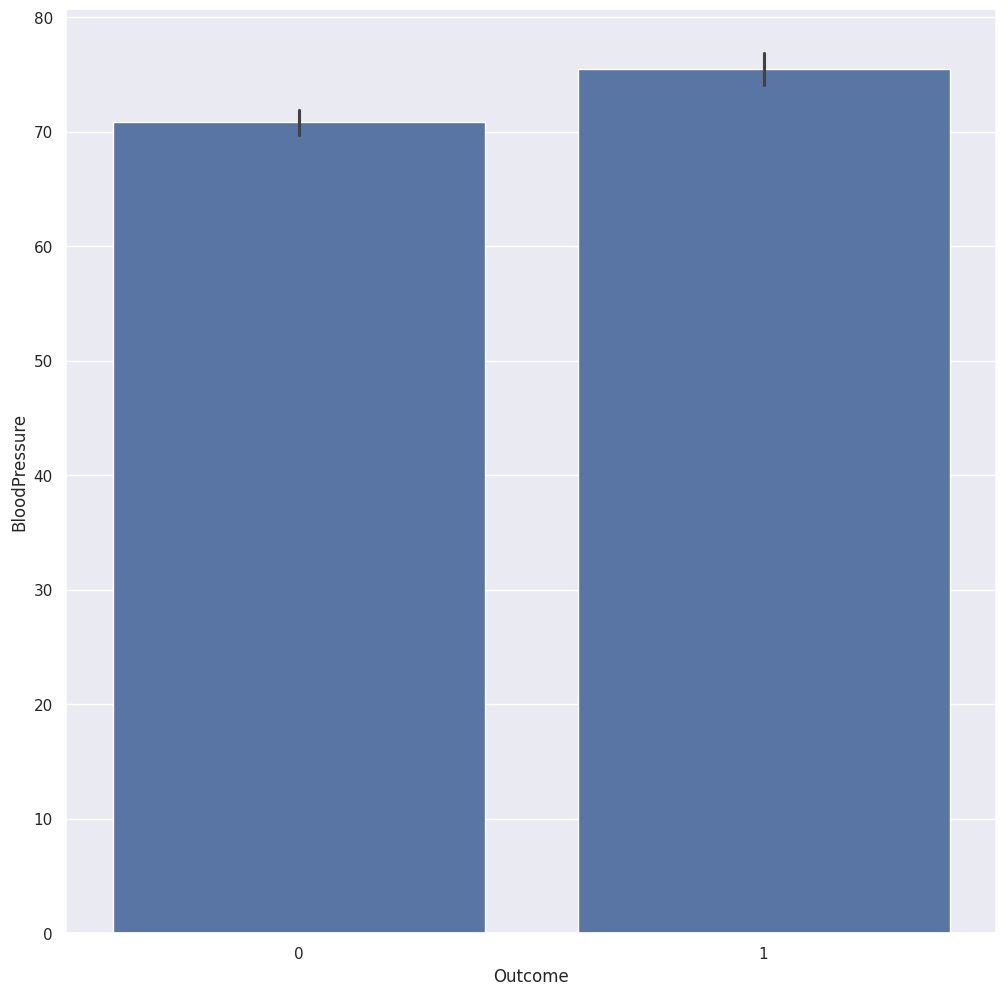

         SkinThickness_mean
Outcome                    
0                    26.698
1                    32.186




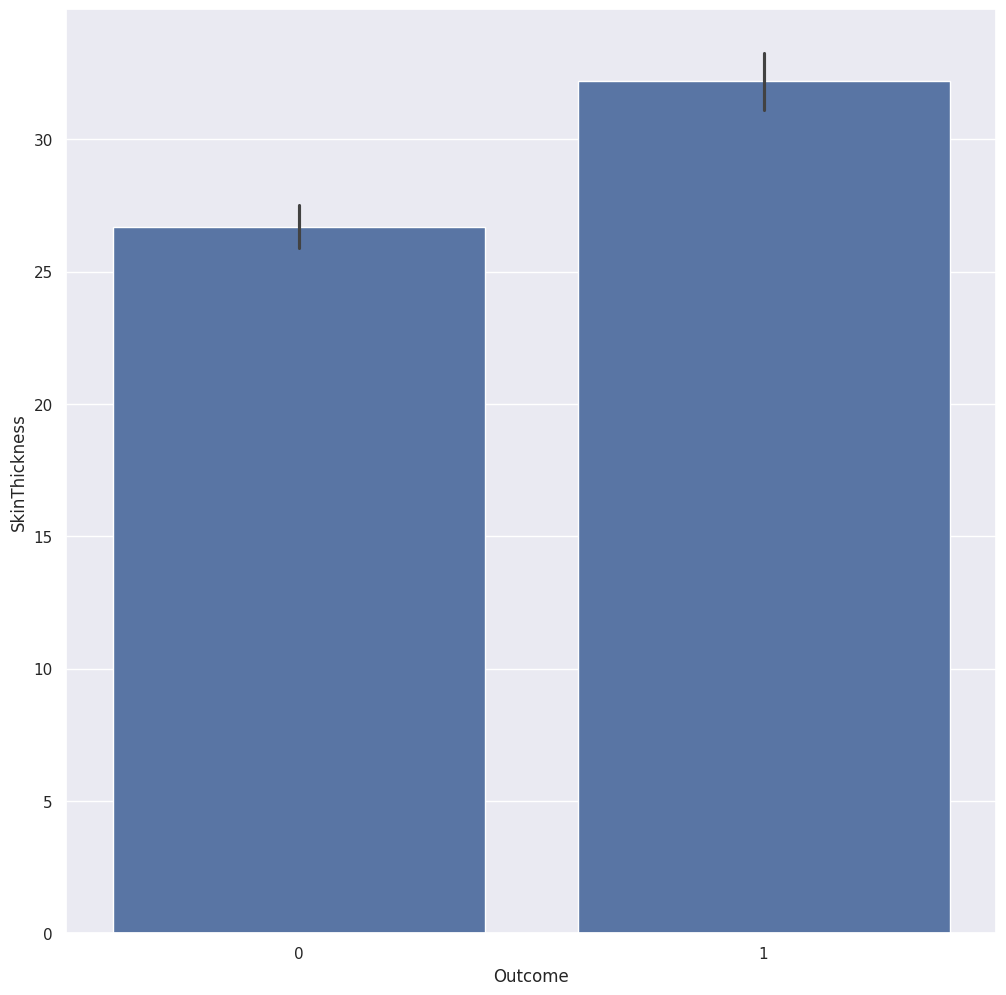

         Insulin_mean
Outcome              
0             126.532
1             194.583




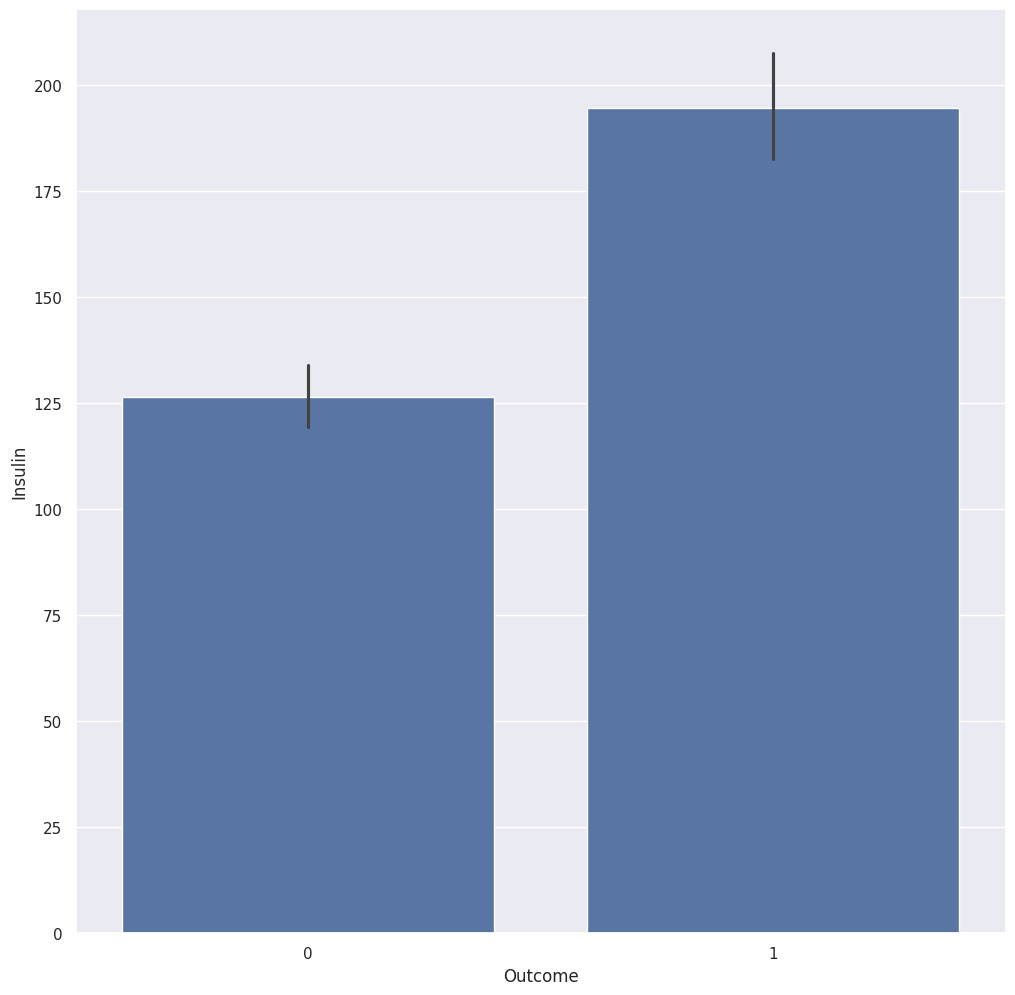

         BMI_mean
Outcome          
0          30.869
1          35.400




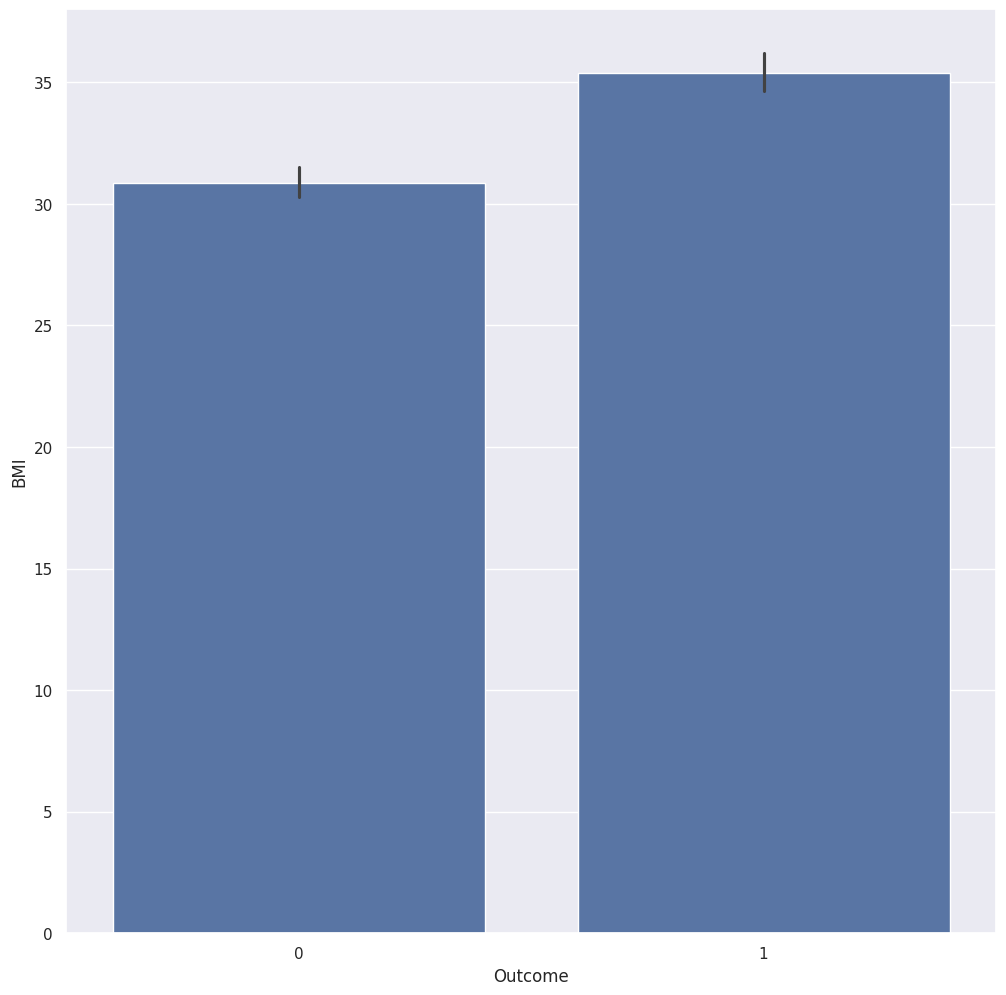

         DiabetesPedigreeFunction_mean
Outcome                               
0                                0.430
1                                0.550




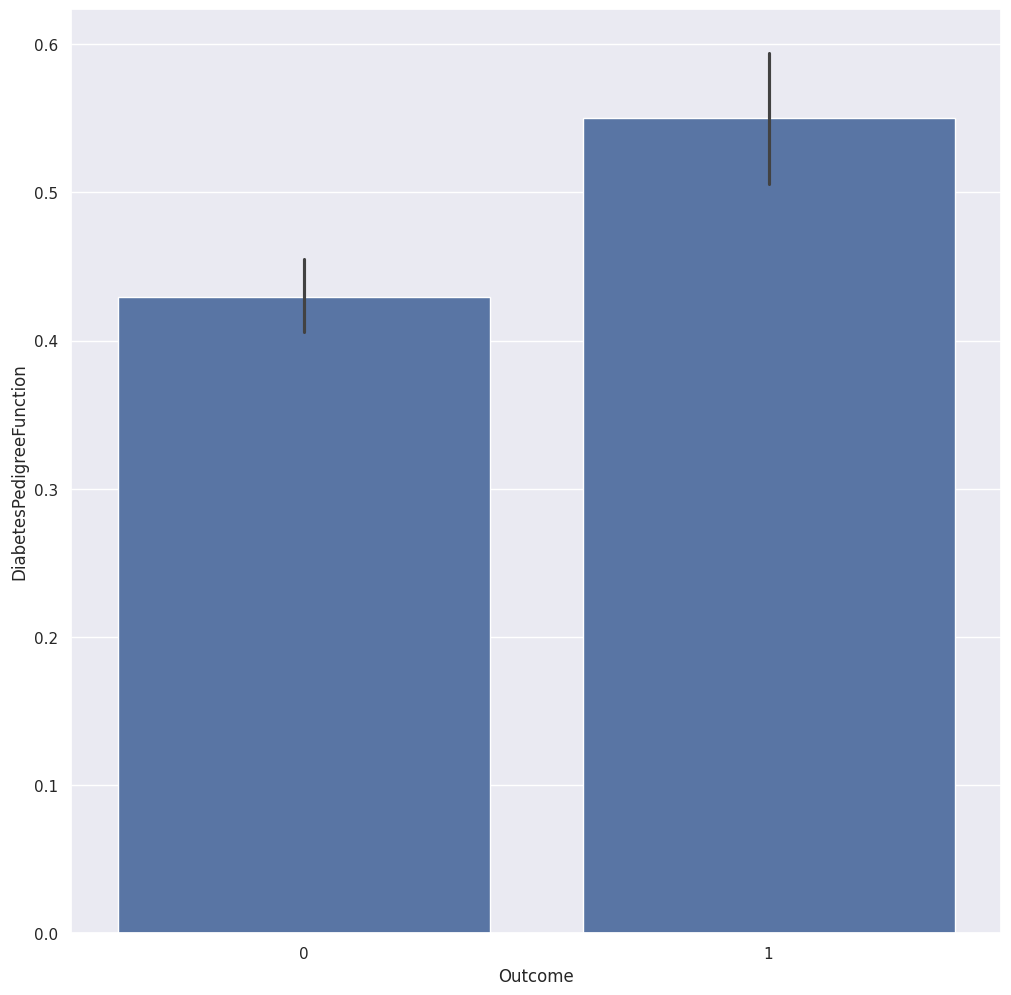

         Age_mean
Outcome          
0          31.190
1          37.067




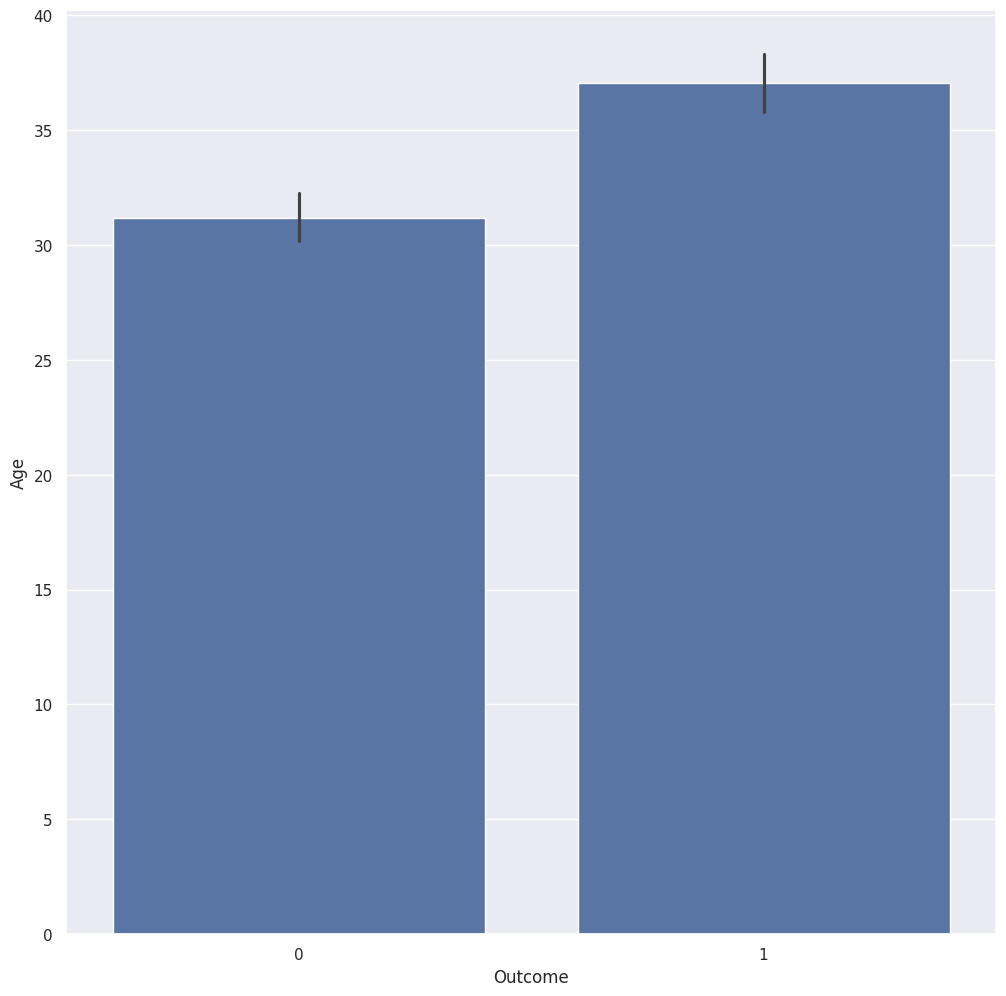

In [51]:
for col in num_cols:
    target_summary_with_num(df, "Outcome", col, plot=True)

### Examining the Logarithm of the Dependent Variable

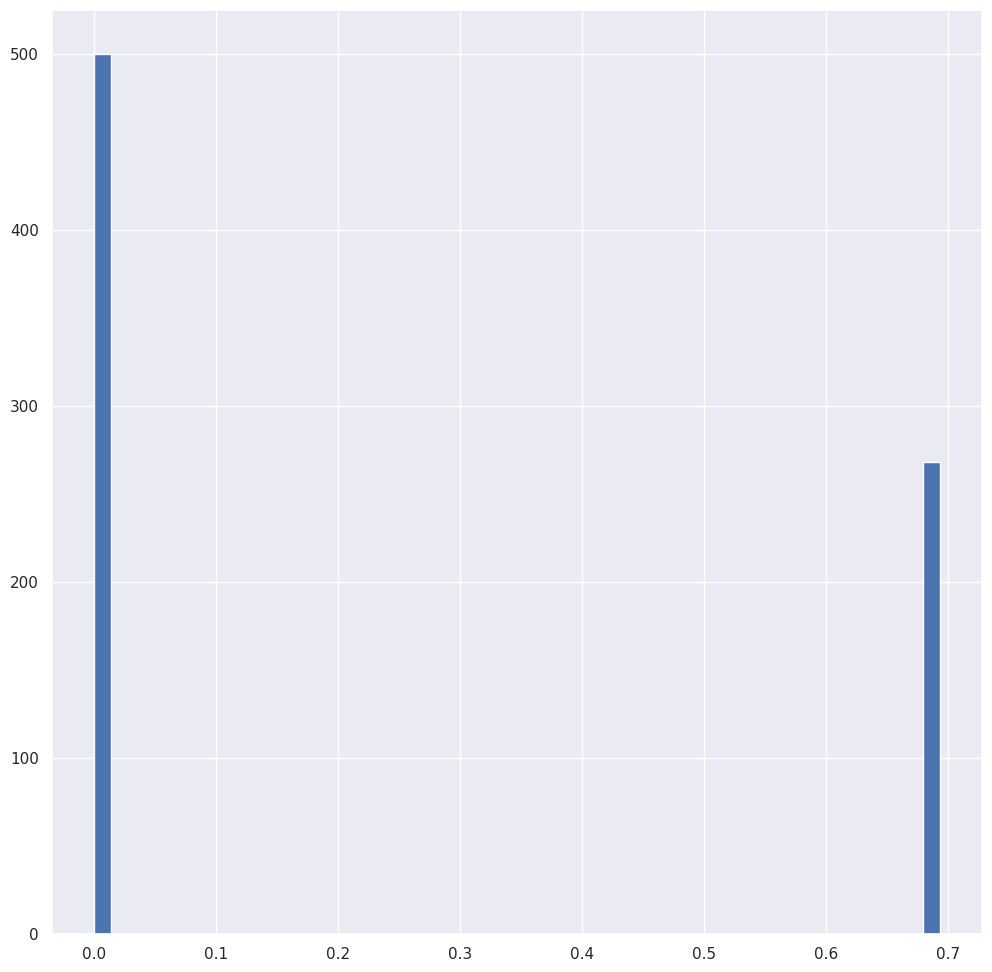

In [52]:
np.log1p(df["Outcome"]).hist(bins=50)
plt.show(block=True)

# Handle categorical variables (one-hot encoding, label encoding).

In [53]:
print(df.dtypes)

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [54]:
df = pd.get_dummies(df, columns=['Outcome'], drop_first=True)

In [55]:
corr_matrix = df.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]

df.drop(columns=high_corr_features, inplace=True)

In [56]:
print("Dropped columns:", high_corr_features)

Dropped columns: []


In [57]:
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(columns=['Outcome_1'])
y = df['Outcome_1']

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

In [58]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
selected_features = mi_scores.nlargest(5).index
X_selected = X[selected_features]

In [59]:
print(mi_scores.sort_values(ascending=False))  # Show MI scores
print("Selected Features:", selected_features.tolist())  # Show top 5 features
print(X_selected.head())  # Show first few rows of the selected dataset

Glucose                    0.114
BMI                        0.088
Insulin                    0.061
Age                        0.046
SkinThickness              0.023
Pregnancies                0.019
DiabetesPedigreeFunction   0.013
BloodPressure              0.000
dtype: float64
Selected Features: ['Glucose', 'BMI', 'Insulin', 'Age', 'SkinThickness']
   Glucose    BMI  Insulin  Age  SkinThickness
0  148.000 33.600  196.000   50         35.000
1   85.000 26.600   73.600   31         29.000
2  183.000 23.300  218.200   32         25.600
3   89.000 28.100   94.000   21         23.000
4  137.000 43.100  168.000   33         35.000


# Split the dataset into training and testing sets (80-20 or 70-30 split).

In [60]:
# Creating the Dependent Variable.

y = df["Outcome_1"]

# Creating Independent Variables.

X = df.drop("Outcome_1", axis=1)

# Splitting the Data into Training and Test Sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [61]:
# Random Forest Classifier Model Training

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

# Prediction using Random Forest Classifier Model

y_pred = rf_model.predict(X_test)

print("RandomForestClassifier:")
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(y_pred,y_test),4)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 4)}")
print(f"F1: {round(f1_score(y_pred,y_test), 4)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 4)}")

RandomForestClassifier:
Accuracy: 0.7619
Recall: 0.6912
Precision: 0.5802
F1: 0.6309
Auc: 0.7413


In [62]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print("Logistic Regression:")
print(f"Accuracy: {round(accuracy_score(lr_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(lr_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(lr_pred, y_test), 4)}")
print(f"F1: {round(f1_score(lr_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(lr_pred, y_test), 4)}")

Logistic Regression:
Accuracy: 0.7489
Recall: 0.6825
Precision: 0.5309
F1: 0.5972
AUC: 0.7282


In [63]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)

print("K-Nearest Neighbors (KNN):")
print(f"Accuracy: {round(accuracy_score(knn_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(knn_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(knn_pred, y_test), 4)}")
print(f"F1: {round(f1_score(knn_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(knn_pred, y_test), 4)}")

K-Nearest Neighbors (KNN):
Accuracy: 0.7446
Recall: 0.6375
Precision: 0.6296
F1: 0.6335
AUC: 0.7194


In [64]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

print("Decision Tree Classifier:")
print(f"Accuracy: {round(accuracy_score(dt_pred, y_test), 4)}")
print(f"Recall: {round(recall_score(dt_pred, y_test), 4)}")
print(f"Precision: {round(precision_score(dt_pred, y_test), 4)}")
print(f"F1: {round(f1_score(dt_pred, y_test), 4)}")
print(f"AUC: {round(roc_auc_score(dt_pred, y_test), 4)}")

Decision Tree Classifier:
Accuracy: 0.7013
Recall: 0.5714
Precision: 0.5926
F1: 0.5818
AUC: 0.6735


### Comparison of Metrics for Different Models

In [65]:
# Dictionary containing the metric results
metrics = {
    "Model": ["Random Forest", "Logistic Regression", "KNN", "Decision Tree"],
    "Accuracy": [0.7706, 0.7879, 0.7619, 0.7186],
    "Recall": [0.7059, 0.7667, 0.6711, 0.6053],
    "Precision": [0.5926, 0.5679, 0.6296, 0.56796],
    "F1": [0.6443, 0.6525, 0.6497, 0.586],
    "AUC": [0.7517, 0.781, 0.7388, 0.6897]
}

# Creating a DataFrame from the metrics dictionary
results_df = pd.DataFrame(metrics)

# Sorting the DataFrame by accuracy in descending order
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Creating the figure for the graph
fig = go.Figure()

# Colors for the metrics
colors = ["purple", "green", "blue", "orange", "red"]

# Adding traces for each metric in the specified order
for metric, color in zip(["Accuracy", "Recall", "Precision", "F1", "AUC"], colors):
    fig.add_trace(go.Bar(
        x=results_df["Model"],
        y=results_df[metric],
        marker_color=color,
        name=metric,
        text=results_df[metric],
        textposition='auto'
    ))

# Setting axis labels and title
fig.update_layout(
    xaxis_title="Model",
    yaxis_title="Metric Score",
    title="Comparison of Metrics for Different Models"
)

# Displaying the graph
fig.show(block=True)

### Visualization of the Decision Tree

|--- feature_1 <= 127.50
|   |--- feature_7 <= 28.50
|   |   |--- feature_5 <= 45.40
|   |   |   |--- class: False
|   |   |--- feature_5 >  45.40
|   |   |   |--- class: True
|   |--- feature_7 >  28.50
|   |   |--- feature_4 <= 95.90
|   |   |   |--- class: False
|   |   |--- feature_4 >  95.90
|   |   |   |--- class: False
|--- feature_1 >  127.50
|   |--- feature_5 <= 28.15
|   |   |--- feature_1 <= 145.50
|   |   |   |--- class: False
|   |   |--- feature_1 >  145.50
|   |   |   |--- class: False
|   |--- feature_5 >  28.15
|   |   |--- feature_1 <= 158.50
|   |   |   |--- class: True
|   |   |--- feature_1 >  158.50
|   |   |   |--- class: True



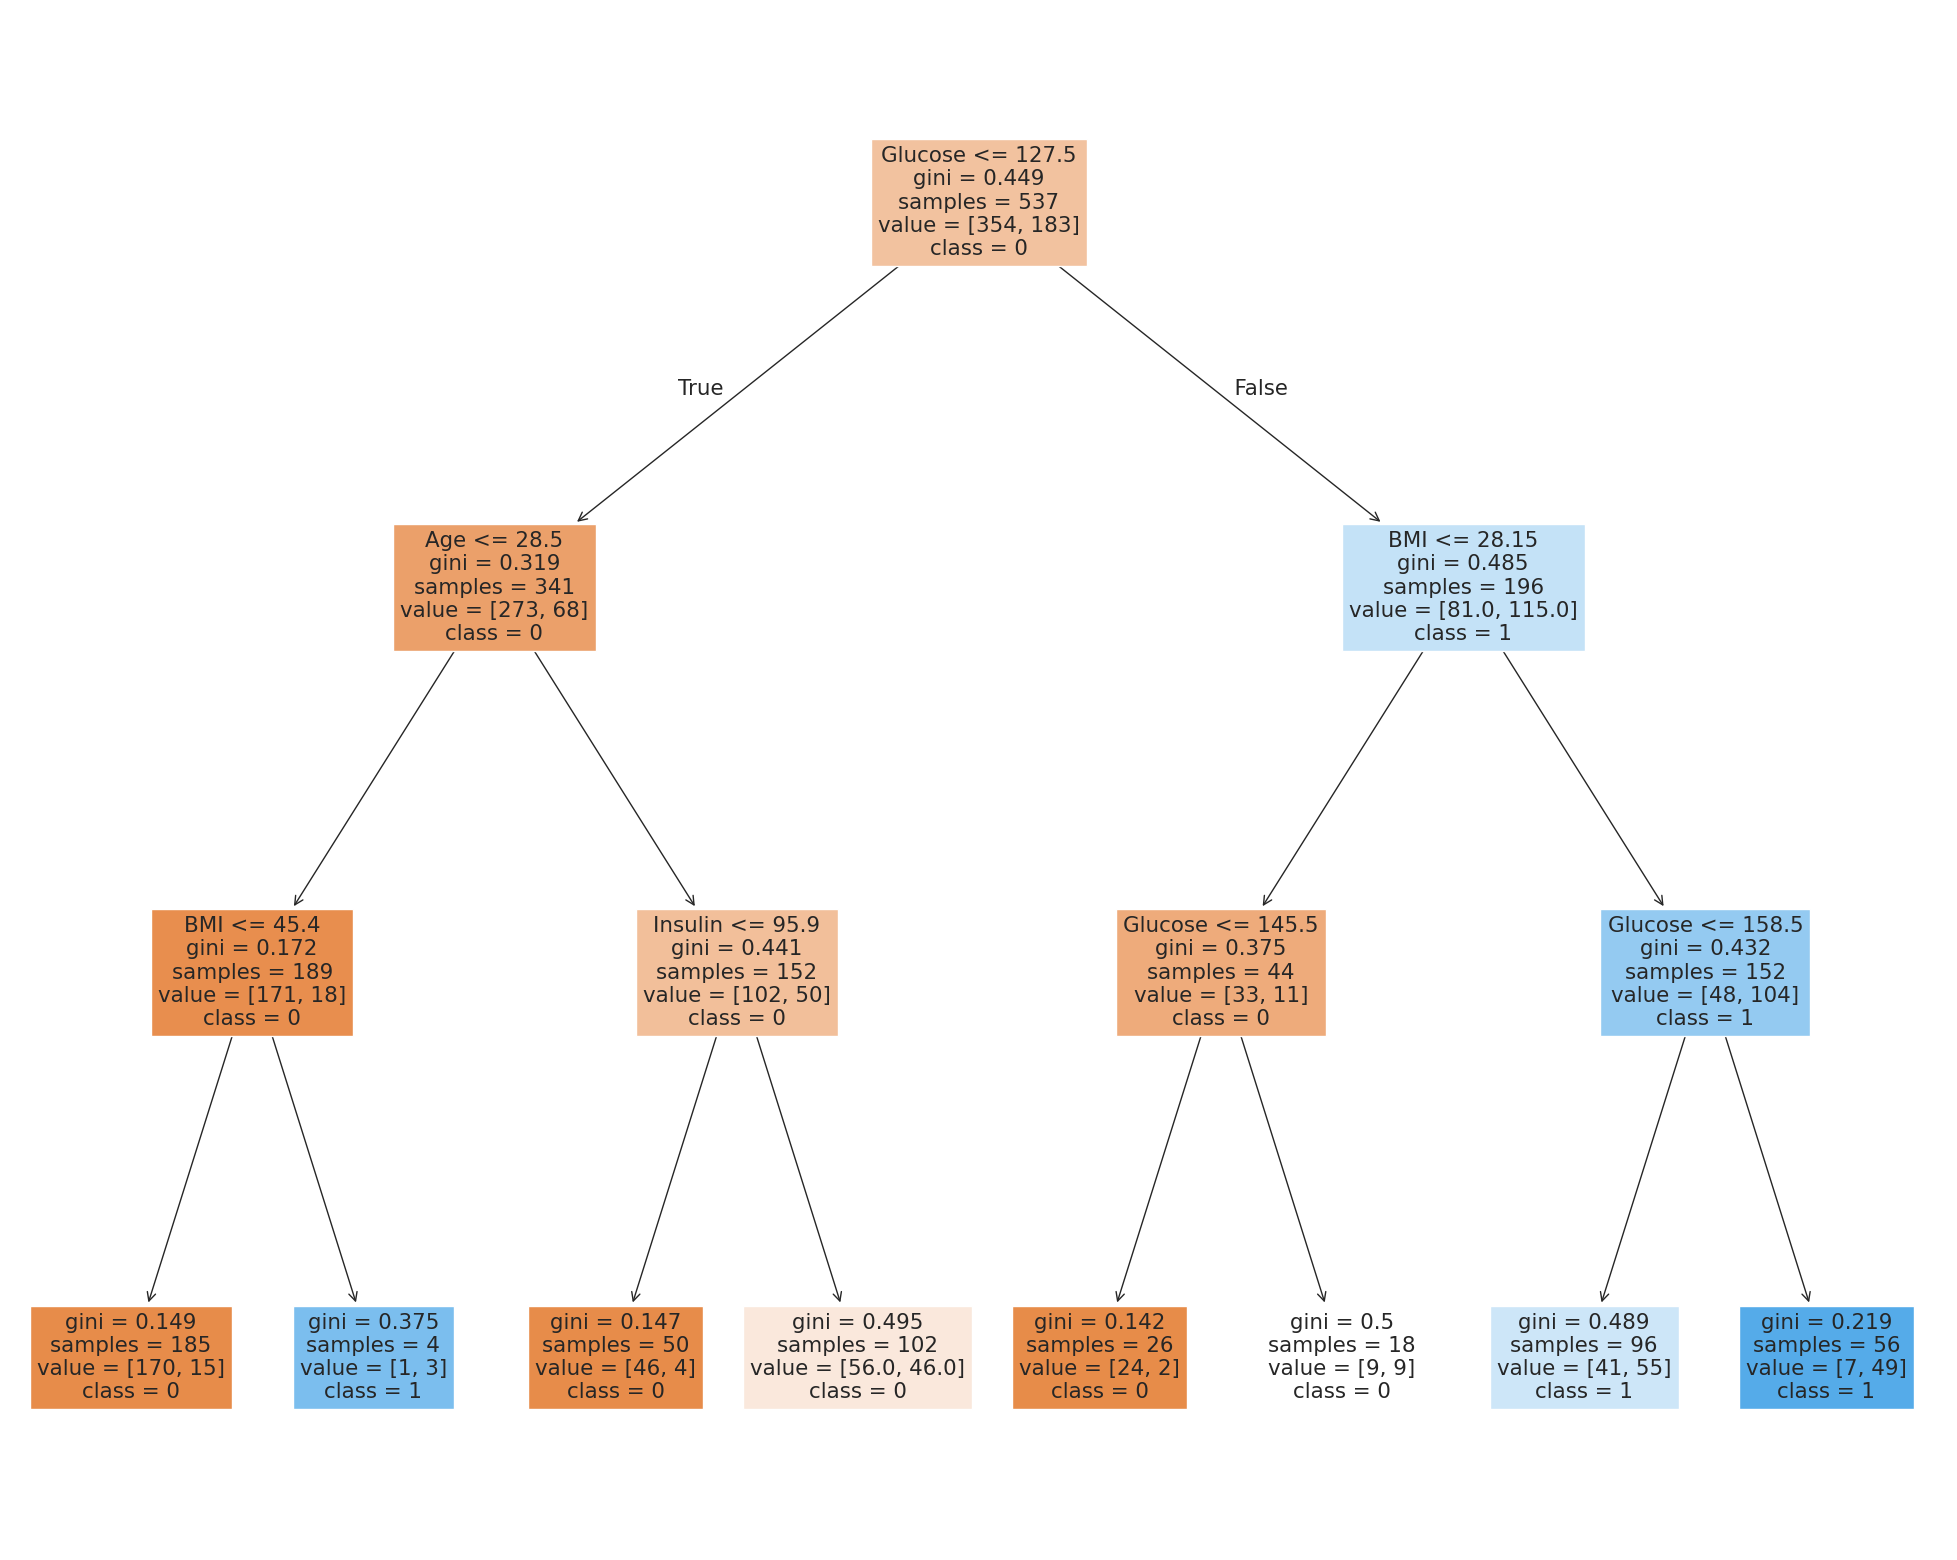

In [66]:
# Loading the dataset and setting the features and target variable
x = pd.DataFrame(df, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = df.Outcome_1.values.reshape(-1, 1)

# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Defining and training the Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(x_train, y_train)

# Making predictions on the test set
y_pred = clf.predict(x_test)

# Generating the text representation of the decision tree and printing it
text_representation = tree.export_text(clf)
print(text_representation)

# Setting the feature and target class names
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
target_names = ['0', '1']

# Generating and saving the visualization of the decision tree
fig = plt.figure(figsize=(25, 20))
plot = tree.plot_tree(clf, feature_names=feature_names, class_names=target_names, filled=True)
fig.savefig('tree1.png')

### Plot Importance of Variables According to Base Model

In [67]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title(f'Feature Importance - {model.__class__.__name__}')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

In [68]:
model_name = [rf_model, dt_model]

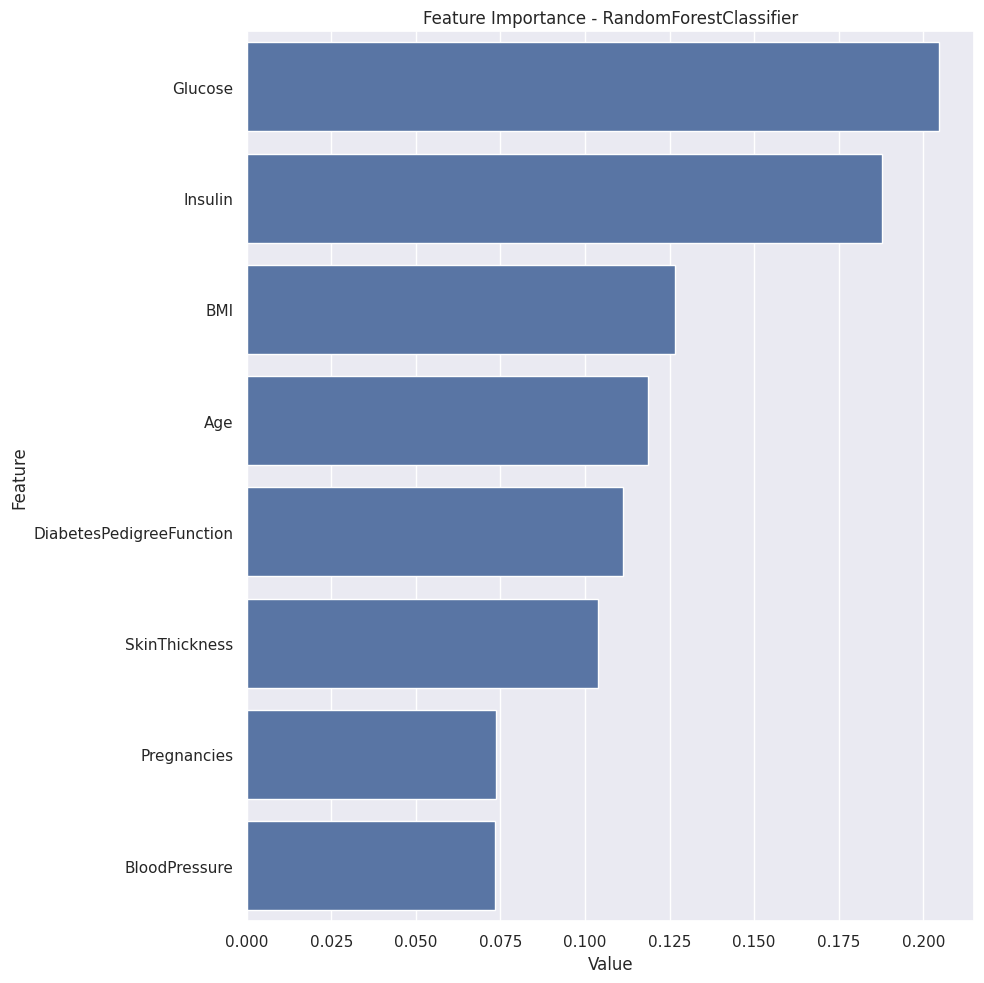

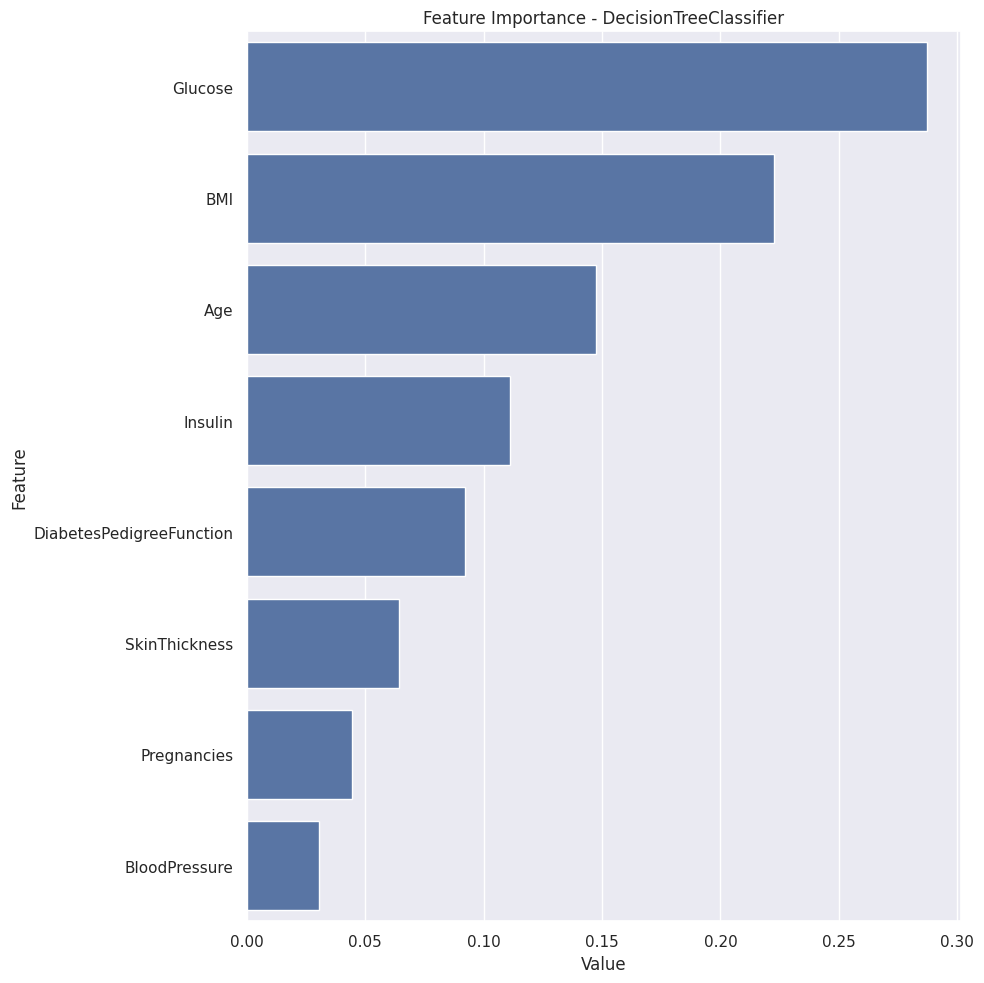

In [69]:
for i in model_name:
    plot_importance(i, X)

# Tune hyperparameters using GridSearchCV or RandomizedSearchCV.

In [70]:
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

In [71]:
print(np.unique(y_pred, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([False,  True]), array([152,  79]))
(array([False,  True]), array([146,  85]))


In [72]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [73]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(class_weight="balanced", random_state=42)
best_rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight="balanced", random_state=42),
                           param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, y_train_resampled)

best_rf = grid_search.best_estimator_

# Train and evaluate models using metrics such as accuracy, precision, recall, and F1-score.

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")


Accuracy: 0.57, Precision: 0.41, Recall: 0.35, F1-score: 0.38


# Evaluate models using confusion matrix, Precision Recall Curve.

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = best_rf.predict(X_test)  # Assuming best_rf is your trained model
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[102  44]
 [ 55  30]]
Classification Report:
               precision    recall  f1-score   support

       False       0.65      0.70      0.67       146
        True       0.41      0.35      0.38        85

    accuracy                           0.57       231
   macro avg       0.53      0.53      0.53       231
weighted avg       0.56      0.57      0.56       231



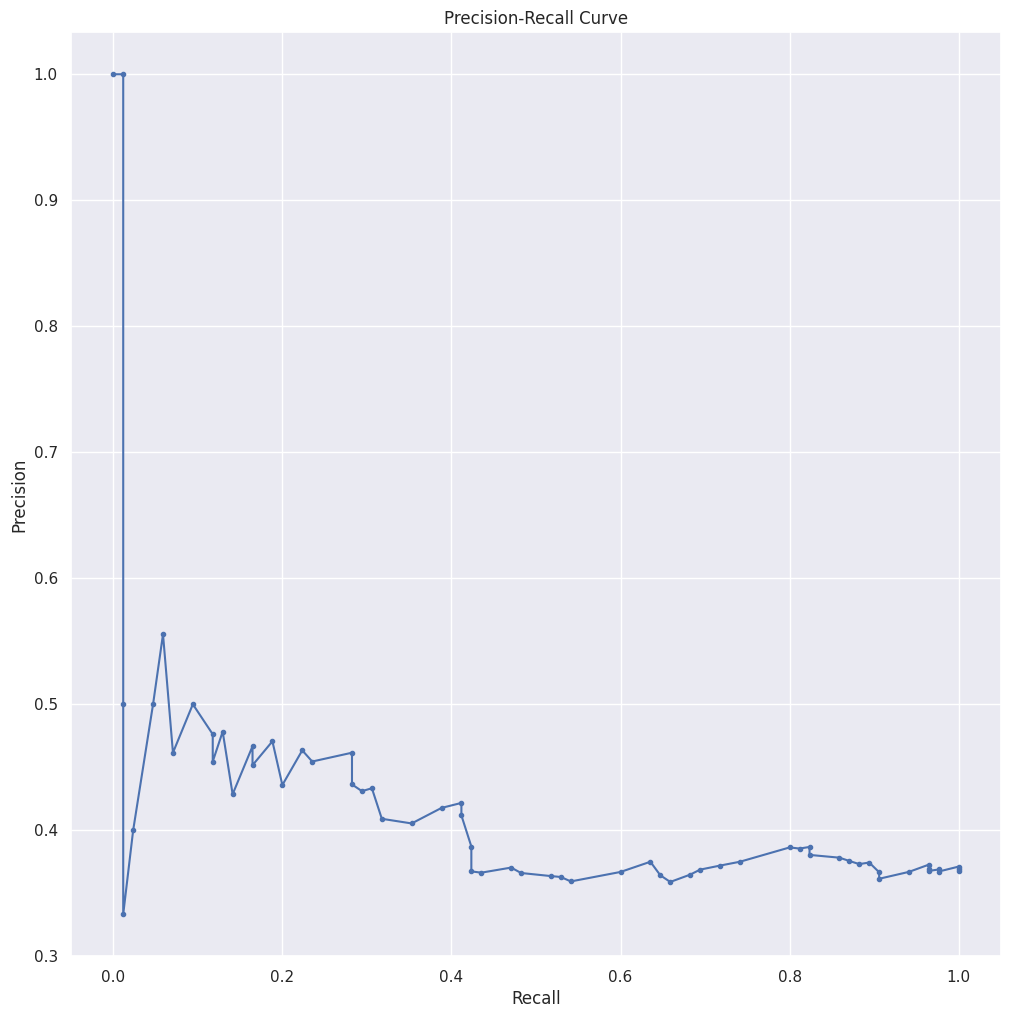

In [77]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = best_rf.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

1. Evaluation Using Confusion Matrix & Precision-Recall Curve
The confusion matrix:

lua
Copy
Edit
[[102  44]
 [ 55  30]]
True Negatives (TN): 102

False Positives (FP): 44

False Negatives (FN): 55

True Positives (TP): 30

Interpretation:

The model correctly predicted 102 non-diabetic cases but misclassified 44 as diabetic.

It correctly identified 30 diabetic cases but failed to classify 55 as diabetic.

Accuracy: 57% (low)

Precision for diabetic cases (True class): 41% → Only 41% of positive predictions were correct.

Recall for diabetic cases: 35% → The model detected only 35% of actual diabetic cases.

The Precision-Recall curve shows fluctuating precision at different recall levels, indicating poor discrimination power.

2. Results Interpretation & Suggested Improvements
The model has low recall (35%), meaning it fails to detect many actual diabetic cases, which is critical in healthcare applications.

The low precision (41%) also means there are many false positives, leading to unnecessary medical tests or concerns.

Suggestions for improvement:

Feature Selection: Select the most important features and remove irrelevant ones.

Hyperparameter Tuning: Optimize parameters of the Random Forest model.

Balancing the Dataset: If the dataset is imbalanced, apply SMOTE or other resampling techniques.

Using a Different Model: Consider trying Logistic Regression, SVM, or Neural Networks.

# Apply feature selection techniques and retrain the model if necessary.

In [78]:
feature_importances = best_rf.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]

df_importance = pd.DataFrame({
    "Feature": feature_names[sorted_indices],
    "Importance": feature_importances[sorted_indices]
})
print(df_importance.head(10))  # Top 10 important features

                    Feature  Importance
0                       BMI       0.140
1  DiabetesPedigreeFunction       0.140
2             SkinThickness       0.135
3                   Glucose       0.134
4             BloodPressure       0.127
5                   Insulin       0.126
6                       Age       0.114
7               Pregnancies       0.084


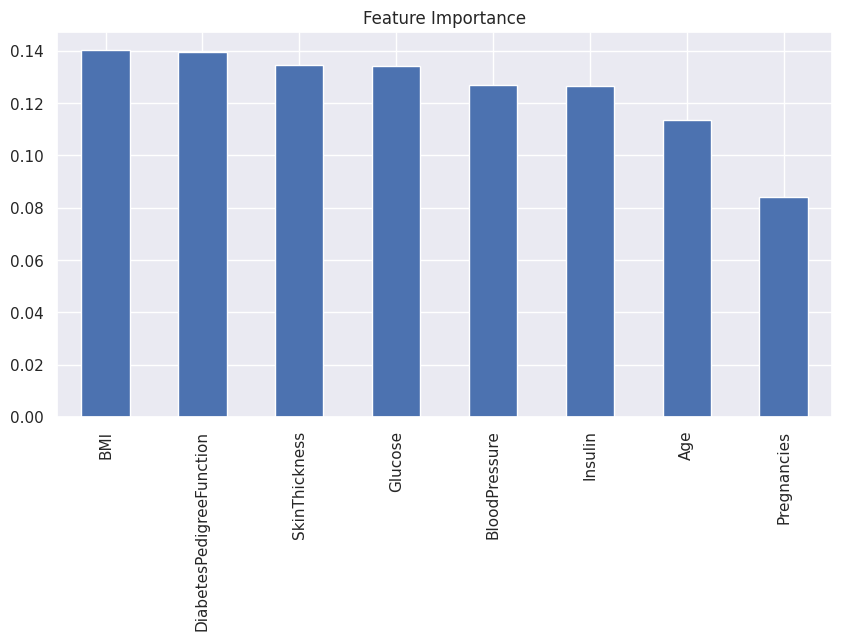

In [79]:
# Get feature importance from the trained model
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_resampled.columns)

# Sort and visualize
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title("Feature Importance")
plt.show()

In [80]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(df)

In [81]:
selected_features = ["Glucose", "BMI"]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

best_rf.fit(X_train_selected, y_train)
print("Retrained Model with Selected Features: Glucose and BMI")

Retrained Model with Selected Features: Glucose and BMI


In [82]:
import numpy as np
df["log_Insulin"] = np.log1p(df["Insulin"])
df["log_DiabetesPedigreeFunction"] = np.log1p(df["DiabetesPedigreeFunction"])

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [84]:
df = df.drop(columns=["Pregnancies"])

# Save the best model using Pickle/Joblib.

In [86]:
!pip install streamlit -q

In [87]:
from joblib import dump, load

dump(best_rf, 'best_model.joblib')

['best_model.joblib']

In [88]:
loaded_model = load('best_model.joblib')

In [89]:
!wget -q -O - ipv4.icanhazip.com

34.60.142.168


# Develop a Flask or Streamlit web application where users can input patient details and receive a disease prediction.

In [90]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np

# Load the trained model
model = joblib.load("best_model.joblib")

# Streamlit app title
st.title("Diabetes Prediction Web App")

st.markdown("### Enter Patient Details")

# Input fields
glucose = st.number_input("Glucose Level", min_value=0, max_value=300, value=120)
bmi = st.number_input("BMI", min_value=10.0, max_value=50.0, value=25.0)

# Prediction button
if st.button("Predict"):
    input_data = np.array([[glucose, bmi]])
    prediction = model.predict(input_data)[0]
    st.success(f"The model predicts: {'Diabetes Present' if prediction == 1 else 'No Diabetes'}")

Overwriting app.py


In [91]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.60.142.168:8501

⠼⠴⠦⠧your url is: https://fresh-parts-tie.loca.lt
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature nam